Here, a hybrid CNN-LSTM agent localization in an
indoor environment model based on WSN nodes'RSSI is presented.

We use four anchor nodes as beacons and one is carried by the mobile agent.

Our approach consists in transforming a WSN RSSI dataset into heatmap images (representing RSSI of the 4 beacons on a map, for each location of the mobile node) and then to apply computer vision techniques to predict the location.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Runtime -> Change runtime type-> GPU
! nvidia-smi

Mon Feb  7 13:50:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
sns.set()
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]

## Dataset

In [5]:
path = '/content/drive/MyDrive/Projet Transcversal /rssi.csv'
data = pd.read_csv(path)
data.head()

,ap,signal,sequence,x,y,z
0,A,11.0,0.0,22.0,17.0,2.0
1,A,10.0,1.0,22.0,17.0,2.0
2,A,10.0,2.0,22.0,17.0,2.0
3,A,9.0,3.0,22.0,17.0,2.0
4,A,11.0,4.0,22.0,17.0,2.0


The samples were taken in a two-level building. Each row in the dataset is a single RSSI sample from one of the 4 access points.
Access points are identified by one of the letters A, B, C, or D. Physical coordinates of the location where each sample was taken is identified by X,Y, Z coordinates with Z being the floor (1 or 2). At each coordinate, multiple samples are taken.

ap: Access point identifier. one of A, B, C or D

signal: Signal strength from access point ap. Note: RSSI values in the table are negated. That is, smaller values in this cell mean stronger signal reception from the access point.

sequence: The sequence of sample from this particular access point at this particular coordinate

x,y,z:: Coordinates where this sample was taken

### Original data visualization

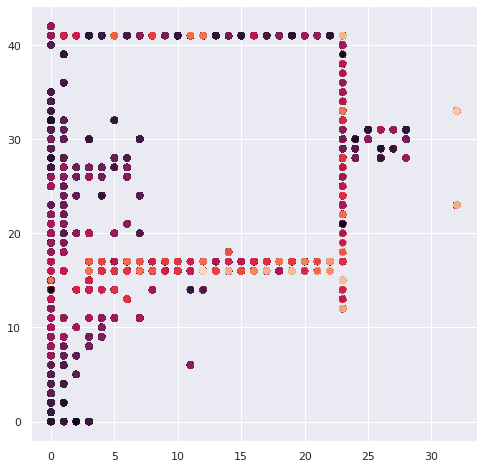

In [6]:
fig = plt.figure(figsize=(8, 8))
from itertools import product
for floor in range(1,3) :
  for ap in ("A","B","C","D"):
    
    mask = (data.z == floor) & (data.ap == ap)
    signal = data[mask][["signal", "x", "y"]]
    plt.scatter(signal.x, signal.y, c=signal.signal)
    

### Heatmaps generation

In [7]:
df1 = data[data.z==1.0].groupby(['x','y','z','ap']).mean('signal')
df2 = data[data.z==2.0].groupby(['x','y','z','ap']).mean('signal')
df1

signal  sequence
x    y    z   ap                     
0.0  0.0  1.0 A   15.182432      73.5
              B   31.117155     119.0
              D   14.769231       6.0
     1.0  1.0 A   12.793103     101.0
              B   29.415663      82.5
...                     ...       ...
32.0 23.0 1.0 B   17.239521      83.0
              C   34.776316      37.5
     33.0 1.0 A   12.257353      67.5
              B    7.232704      79.0
              C   33.628571      52.0

[495 rows x 2 columns]

In [11]:
df = df1 # floor 1
new_data=[]

ap = {}
xyz = df.iloc[0].name[:3]

for i in range(df.shape[0]):
  name = df.iloc[i].name # (x,y,z,ap)
  name = name[:3]

  if name[:3] != xyz:
    xyz = name[:3]
    #plot
    new_data.append([xyz,ap])
    ap = {}
  else:
    ap[df.iloc[i].name[3]] = df.iloc[i][0]
  
#new_data[0][1]['s']
new_data

[[(0.0, 1.0, 1.0),
  {'A': 15.182432432432432, 'B': 31.11715481171548, 'D': 14.76923076923077}],
 [(0.0, 2.0, 1.0), {'B': 29.41566265060241, 'D': 13.387096774193548}],
 [(0.0, 3.0, 1.0), {'B': 25.404411764705884, 'D': 9.125}],
 [(0.0, 4.0, 1.0), {'B': 31.123893805309734, 'D': 12.963636363636363}],
 [(0.0, 5.0, 1.0), {'B': 30.466666666666665, 'D': 17.185185185185187}],
 [(0.0, 6.0, 1.0),
  {'B': 29.470588235294116, 'C': 5.375, 'D': 15.03225806451613}],
 [(0.0, 7.0, 1.0),
  {'B': 38.96363636363636, 'C': 5.741935483870968, 'D': 11.214285714285714}],
 [(0.0, 8.0, 1.0),
  {'B': 42.110169491525426, 'C': 5.593220338983051, 'D': 15.887640449438202}],
 [(0.0, 9.0, 1.0),
  {'B': 40.101010101010104, 'C': 7.018867924528302, 'D': 21.196969696969695}],
 [(0.0, 10.0, 1.0),
  {'B': 34.75257731958763, 'C': 8.8, 'D': 21.595959595959595}],
 [(0.0, 11.0, 1.0),
  {'B': 31.632653061224488, 'C': 5.181818181818182, 'D': 24.397959183673468}],
 [(0.0, 12.0, 1.0),
  {'B': 32.01020408163265, 'C': 4.66666666666666

new_data is a list of positions and the correspondings ap's names and RSSI

i.e. list( [ (x,y,z), {ap_name: rssi} ], ... )

In [9]:
S_map=data.signal.values

In [10]:
labels=[]
for line in new_data:
  labels.append(line[0][:2])

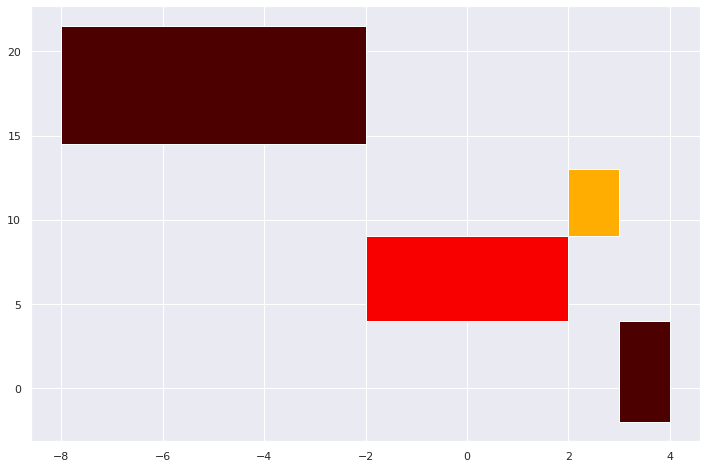

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 0],[0, 0])

#add rectangle to plot
for line in new_data :
    L=[]
    location=line[0]
    d=line[1]
    # case of non existing ap measures
    try:
      L.append(d['A'])
    except:
      L.append(0)
    try:
      L.append(d['B'])
    except:
      L.append(0)    
    try:
      L.append(d['C'])
    except:
      L.append(0)
    try:
      L.append(d['D'])
    except:
      L.append(0)  
    
    cmap = ListedColormap(plt.get_cmap('hot')(np.linspace(0.1, 1, 256)))  # skip too light colors
    norm = plt.Normalize(min(S_map), max(S_map))
    i=0
    # hard-coded APs localisations and range
    for x, y in zip([-8,-2,2,3],[14.5,4,9,-2]):
        
        tex=L[i]
        if i==0:
          width, length=6,7
        elif i==1:
            width, length=4,5
        elif i==2:
          width, length=1,4
        else: 
          width, length=1,6       
        
        ax.add_patch(plt.Rectangle((x , y ), width, length, color=cmap(norm(tex)), ec='white'))
        i+=1

    fig.savefig('/content/drive/MyDrive/Projet Transcversal /data/'+str(location[0])+'_'+str(location[1])+'.png')
    #plt.show()

In RSSI heat maps, the four-square boxes indicate the 4 WSN node RSSI signal strength at a particular location and the x and y-axis are the mobile node coordinates (image label).

The four rectangles with different box size show the RSSI signal characteristics from each node.

To classify the node's signal strength and identify the signal strengths of each node, the heat map uses different size of rectangular boxes.

## Implementation of the AI model

In [53]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda

def ReshapeLayer(x):
   return tf.expand_dims( x, axis=-1)
   
model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=[280, 280, 3]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Lambda(ReshapeLayer)) 
model.add(layers.LSTM(64 ,return_sequences=True))
model.add(layers.Flatten())
model.add(layers.Dense(2))

In [54]:
tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()] # tuple regression problem
)


In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 278, 278, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 139, 139, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 137, 137, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 68, 68, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 295936)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

## Model training

In [56]:
# loading the dataset

import glob
d = glob.glob('/content/drive/MyDrive/Projet Transcversal /data/*.*')
da = []
for i in d:
      
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (280,280))
    image=np.array(image)
    image = image.astype('float')
    da.append(image)


In [57]:
from sklearn.model_selection import train_test_split

dat = np.array(da)
lab = np.array(labels)

X_train, X_test, ytrain, ytest = train_test_split(dat, lab, test_size=0.2, random_state=42)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [59]:
history = model.fit(
    X_train, ytrain,
    epochs=100,
    validation_data=(X_test, ytest),
    callbacks=[early_stop]
) 

Epoch 1/100
4/4 [==============================] - 3s 349ms/step - loss: 413.0383 - mean_squared_error: 413.0383 - val_loss: 326.8123 - val_mean_squared_error: 326.8123
Epoch 2/100
4/4 [==============================] - 1s 139ms/step - loss: 304.8308 - mean_squared_error: 304.8308 - val_loss: 240.7724 - val_mean_squared_error: 240.7724
Epoch 3/100
4/4 [==============================] - 1s 139ms/step - loss: 215.0141 - mean_squared_error: 215.0141 - val_loss: 174.2021 - val_mean_squared_error: 174.2021
Epoch 4/100
4/4 [==============================] - 1s 138ms/step - loss: 156.7476 - mean_squared_error: 156.7476 - val_loss: 147.2368 - val_mean_squared_error: 147.2368
Epoch 5/100
4/4 [==============================] - 1s 138ms/step - loss: 132.4279 - mean_squared_error: 132.4279 - val_loss: 133.1895 - val_mean_squared_error: 133.1895
Epoch 6/100
4/4 [==============================] - 1s 138ms/step - loss: 129.7342 - mean_squared_error: 129.7342 - val_loss: 112.6848 - val_mean_squared_er

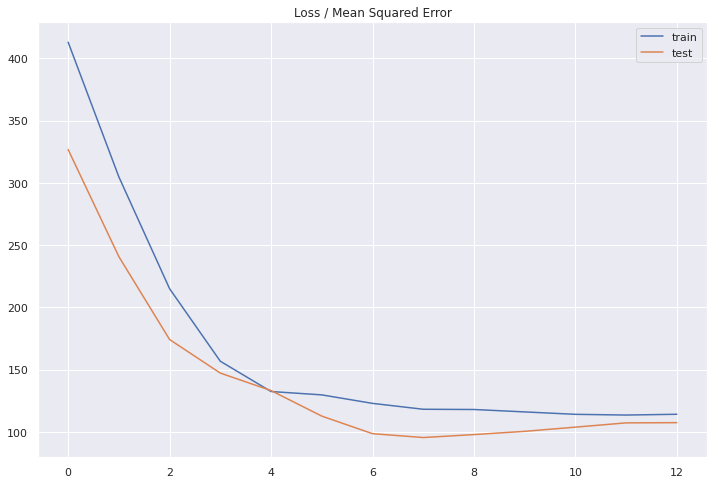

In [60]:
# plot training loss

import matplotlib.pyplot as pyplot

pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model can still be improved but it's already better than the simple ann approach.